In [27]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import multiprocessing
import seaborn as sns

In [28]:
# Função que conta os links de cada nó da rede
def contar_link(rede): 
    N = np.max(rede) + 1 # N é números de nós da rede 
    links = np.zeros(N) # a entrada do array tem a quantidade de link do nó correspondente a entrada
    for l in rede:
        for n in l:
            links[n] += 1
    return links
    
    
# Função que cria a lista de adjacencias de uma rede
def adjacencia(rede):
    graus = contar_link(rede)
    t_lista = int(np.sum(graus))
    lista_adj = np.zeros(t_lista)
    n_max = np.max(rede) # quantidade de nós
    i = 0 # índice lista adjacências
    for n in range(n_max + 1):
        for k in range(len(rede)):
            no_1 = rede[k][0]
            no_2 = rede[k][1]
            if no_1 == n:
                lista_adj[i] = no_2
                i += 1
            if no_2 == n:
                lista_adj[i] = no_1
                i +=1
    return lista_adj



# Função que retorna o vizinhos de um nó
def vizinho_no(n, graus_rede, lista_adj_rede): # n representa o nó
    inicio = 0
    for t in range(int(n)):
        inicio += int(graus_rede[t])
    n_vizinhos = int(graus_rede[n])
    lista_vizinhos_no = np.zeros(n_vizinhos)
    for j in range(n_vizinhos):
        lista_vizinhos_no[j] = lista_adj_rede[inicio]
        inicio += 1
    return lista_vizinhos_no



# Função que verifica se um determinado nó pertence à uma lista
# se pertencer, a função retorna -1
# se não pertencer, a função retorna -2
def verifica(no_dado, lista):
    for no in lista:
        if no == no_dado:
            return -1
    return -2



### Função que calcula o comprimento do caminho mais curto entre o no_i e o no_j 
# usando o metodo BFS
## também retorna a 'queue'
def menor_distancia(no_i, no_j, lista_adj, graus_rede):
    no_i = int(no_i)
    no_j = int(no_j)
    queue = [[no_i]]
    visitados = [no_i]
    while True:
        ultimos = queue[-1]  # camada atual
        # Verifica se o nó destino está nessa camada
        if verifica(no_j, ultimos) != -2:
            break
        vizinhos = []
        for no in ultimos:
            no = int(no) 
            v_no = vizinho_no(no, graus_rede, lista_adj)
            for n in v_no:
                n = int(n)  
                if verifica(n, visitados) == -2:
                    vizinhos.append(n)
                    visitados.append(n)
        queue.append(vizinhos)
    j = len(queue) - 1  # comprimento do caminho
    return int(j), queue



### Função que retorna a matriz distância D da rede
def Matriz_D(N, lista_adj, graus_rede):
    D = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            d, Q = menor_distancia(i, j, lista_adj, graus_rede)
            if i == j:
                D[i, j] = 0
            else:
                D[i, j] = d
                D[j, i] = d
    return D




#### Vamos testar na rede Barabási 
# Função que pega apenas a parte "útil" de uma matriz
def particiona(matriz, indice):
    matriz_particionada = np.zeros((indice, 2), dtype=matriz.dtype)
    for i in range(indice):
        matriz_particionada[i] = matriz[i]
    return matriz_particionada



# Modelo Barabási–Albert (rede livre de escala)
# Cada novo nó se conecta a dois nós existentes com probabilidade
# proporcional ao grau (anexação preferencial)
def Barabasi_Albert(N): 
    C = int(2 * (N - 2) + 1)  # número de conexões
    # Inicializando com zeros e depois preenchendo a rede inicial
    rede_total_p = np.zeros((C + 1, 2), dtype=np.int64)  # C + 1 para garantir espaço suficiente
    rede_total_p[0] = [0, 1]  # rede inicial com apenas dois nós
    t_p = int(2 + 4 * (N - 2))
    
    possibilidades = np.zeros(t_p)
    possibilidades[0] = 0
    possibilidades[1] = 1
    
    n = 2  # Próximo nó a ser adicionado
    i = 1  # Índice para preencher rede_total_p, começando após a rede inicial
    p = 2  # Índice para preencher possibilidades
    for _ in range(1, N - 1):
        rede = particiona(rede_total_p, i)
        
        s1 = np.random.randint(p)
        s2 = np.random.randint(p)
        
        N1 = possibilidades[s1]  # 1º nó sorteado
        N2 = possibilidades[s2]   # 2º nó sorteado
        while N2 == N1:
            s2 = np.random.randint(p)
            N2 = possibilidades[s2] 

        # Preenchendo a matriz com as novas conexões
        rede_total_p[i] = [n, N1]
        rede_total_p[i + 1] = [n, N2]
        
        possibilidades[p] = n
        possibilidades[p + 1] = n
        possibilidades[p + 2] = N1
        possibilidades[p + 3] = N2
        
        n += 1
        i += 2
        p += 4
    return particiona(rede_total_p, i)  # Retornando apenas a parte preenchida da matriz





In [29]:
%%time
## vamos rodar
N = 40 # número de elementos da rede
rede_barabasi = Barabasi_Albert(N) # cria a rede barabasi
graus_rede = contar_link(rede_barabasi) # calcula o grau de cada nó da rede
lista_adj = adjacencia(rede_barabasi) # cria a lista de adjacências da rede
matriz_D = Matriz_D(N, lista_adj, graus_rede) # calcula a matriz distancias da rede


CPU times: user 92.6 ms, sys: 462 µs, total: 93 ms
Wall time: 92.8 ms


/tmp/ipykernel_30897/2800987682.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


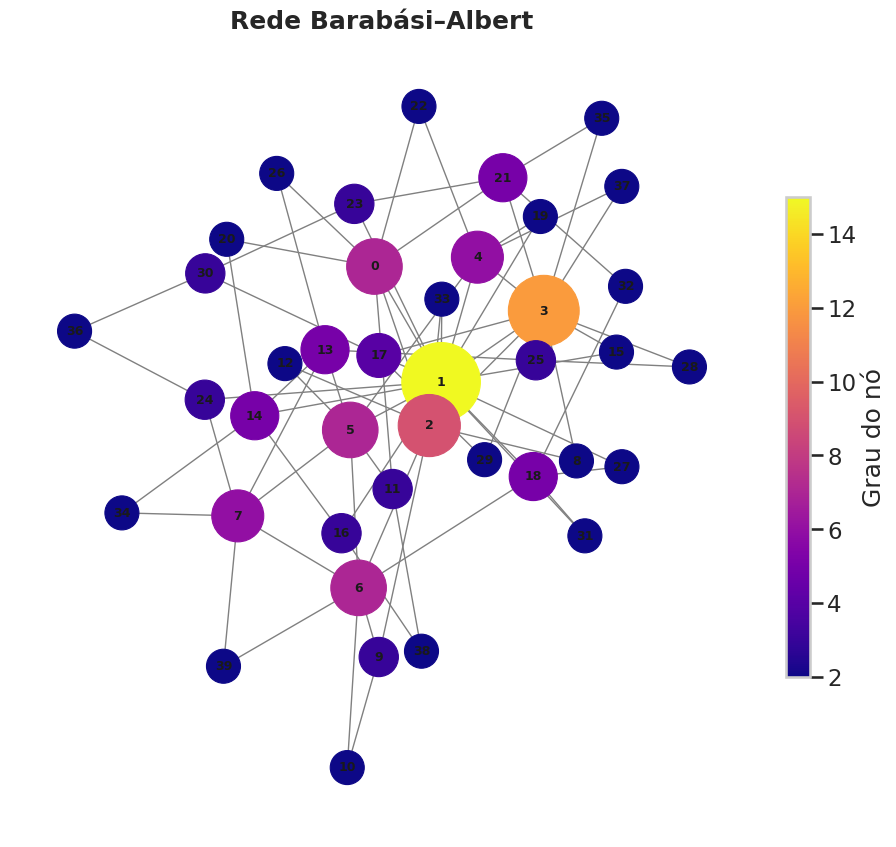

In [30]:
# vamos plotar a rede
# Convertendo o array de arestas para um grafo do NetworkX
G_barabasi = nx.Graph()
G_barabasi.add_edges_from(rede_barabasi)

graus = graus_rede

# tamanho e a cor (dos nós) proporcional ao grau
node_sizes = 200 + 200 * graus  
node_colors = graus             

pos = nx.spring_layout(G_barabasi, seed=42, k=0.3)

# Plotando o grafo
plt.figure(figsize=(8, 8))
nx.draw(
    G_barabasi, pos,
    with_labels=True,
    node_color=node_colors,
    node_size=node_sizes,
    edge_color="gray",
    cmap="plasma",        
    linewidths=0.8,
    font_size=9,
    font_weight='bold'
)

# Adiciona barra de cores
sm = plt.cm.ScalarMappable(cmap="plasma", norm=plt.Normalize(vmin=graus.min(), vmax=graus.max()))
sm.set_array([])
plt.colorbar(sm, label="Grau do nó", fraction=0.03, pad=0.04)

plt.title("Rede Barabási–Albert", fontsize=18, weight='bold')
plt.axis("off")
plt.tight_layout()
plt.show()


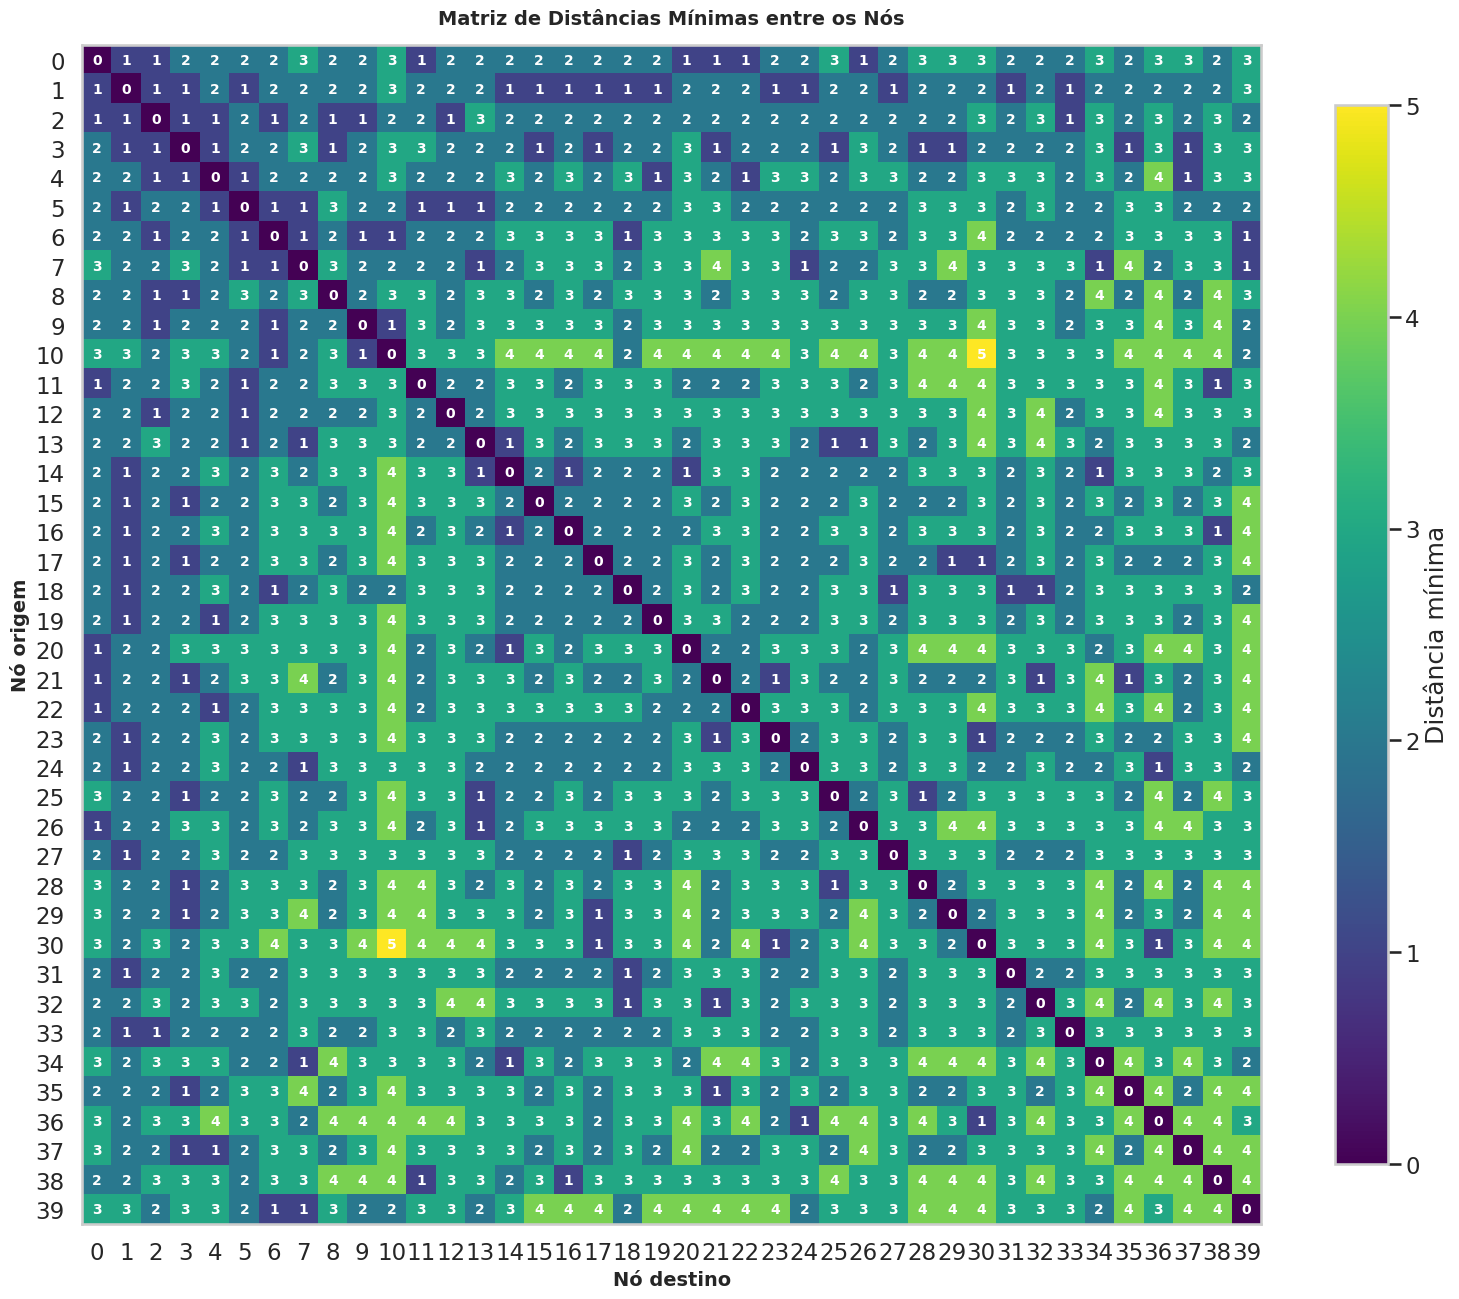

In [31]:
## vamos plotar as distâncias 
plt.figure(figsize=(16, 14))
plt.imshow(matriz_D, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Distância mínima', shrink=0.8)

for i in range(matriz_D.shape[0]):
    for j in range(matriz_D.shape[1]):
        plt.text(j, i, f'{matriz_D[i, j]:.0f}', ha='center', va='center', color='white', fontsize=10, weight='bold')

plt.title('Matriz de Distâncias Mínimas entre os Nós', fontsize=14, pad=15, weight='bold')
plt.xlabel('Nó destino', fontsize=14, weight='bold')
plt.ylabel('Nó origem', fontsize=14, weight='bold')
plt.xticks(np.arange(matriz_D.shape[0]), [f'{i}' for i in range(matriz_D.shape[0])])
plt.yticks(np.arange(matriz_D.shape[0]), [f'{i}' for i in range(matriz_D.shape[0])])
plt.grid(False)
plt.tight_layout()
plt.show()

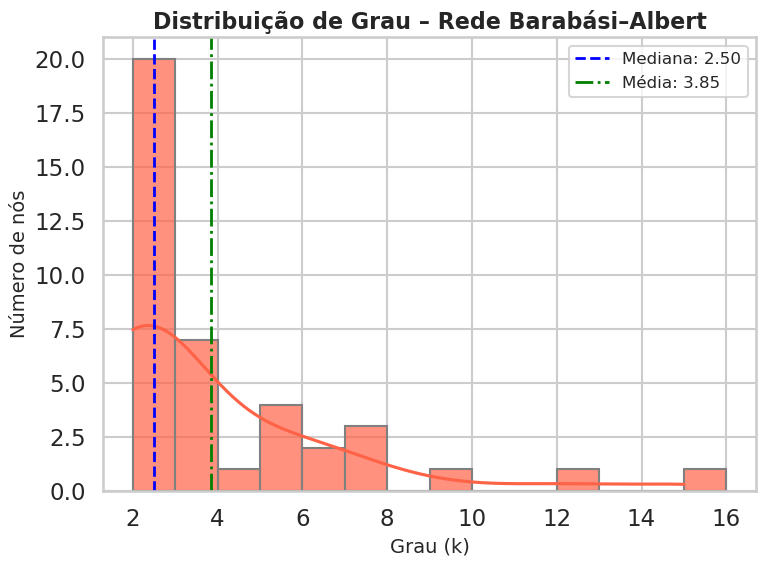

In [32]:
# Histograma com o grau de cada nó
sns.set(style="whitegrid", context="talk")

graus = np.array(graus_rede)
mediana = np.median(graus)
media = np.mean(graus)

# Cria o histograma
plt.figure(figsize=(8, 6))
sns.histplot(graus, bins=range(int(graus.min()), int(graus.max()) + 2),
             color="tomato", edgecolor="gray", alpha=0.7, kde=True)

plt.title("Distribuição de Grau – Rede Barabási–Albert", fontsize=16, weight='bold')
plt.xlabel("Grau (k)", fontsize=14)
plt.ylabel("Número de nós", fontsize=14)

# Linhas de referência
plt.axvline(mediana, color='blue', linestyle='--', linewidth=2,
            label=f"Mediana: {mediana:.2f}")
plt.axvline(media, color='green', linestyle='-.', linewidth=2,
            label=f"Média: {media:.2f}")

plt.legend(frameon=True, fontsize=12)
plt.tight_layout()
plt.show()


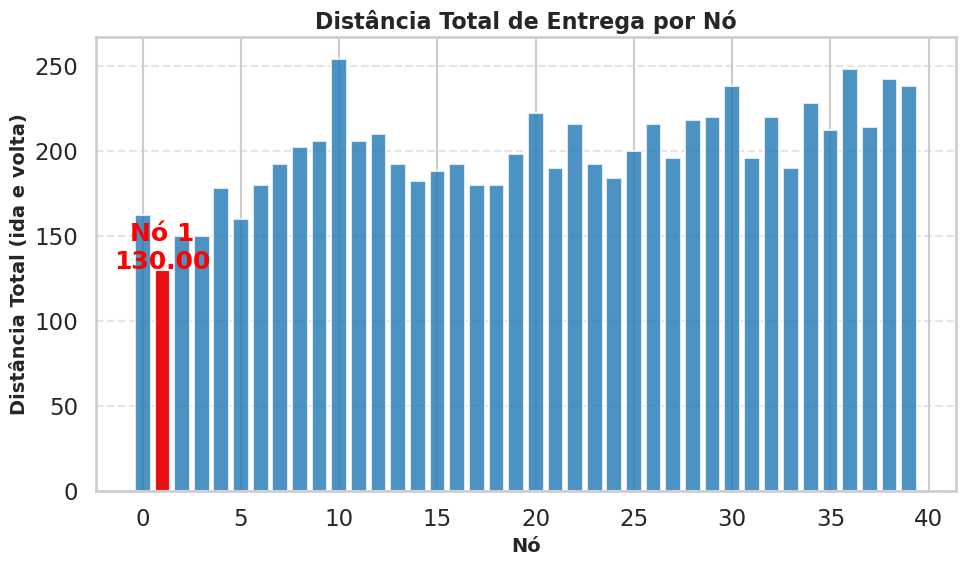

In [33]:
### agora queremos saber qual nó é o ideal para ser o centro de distribuição
### isto é, digamos que você sai do centro de distribuição e precisa entregar em 
### um determinado nó. Você sai do centro de distribuição, realiza a entrega e retorna.
### Qual nó mais eficiente, isto é, o que minimaliza a distância percorrida para realizar 
### entregas em todos os nós?

def no_ideal_logistica(matriz_distancias):
    distancias_cada_no = np.zeros(len(matriz_distancias))
    for i in range(len(matriz_distancias)):
        distancias_cada_no[i] = 2 * np.sum(matriz_distancias[i])
    return distancias_cada_no


# vamos plotar
distancias_cada_no = no_ideal_logistica(matriz_D) #distancias para realizar todas as entregas
nos = np.arange(0, len(matriz_D))

# Encontrar o nó ideal (menor distância total)
no_ideal = np.argmin(distancias_cada_no)
distancia_ideal = distancias_cada_no[no_ideal]


plt.figure(figsize=(10,6))
plt.bar(nos, distancias_cada_no, color='#1f77b4', alpha=0.8)
plt.bar(no_ideal, distancia_ideal, color='red', alpha=0.9)  # nó ideal
plt.text(no_ideal, distancia_ideal + 0.5, f'Nó {no_ideal}\n{distancia_ideal:.2f}', 
         ha='center', color='red', fontweight='bold')
plt.xlabel('Nó', fontsize=14, weight='bold')
plt.ylabel('Distância Total (ida e volta)', fontsize=14, weight='bold')
plt.title('Distância Total de Entrega por Nó', fontsize=16, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


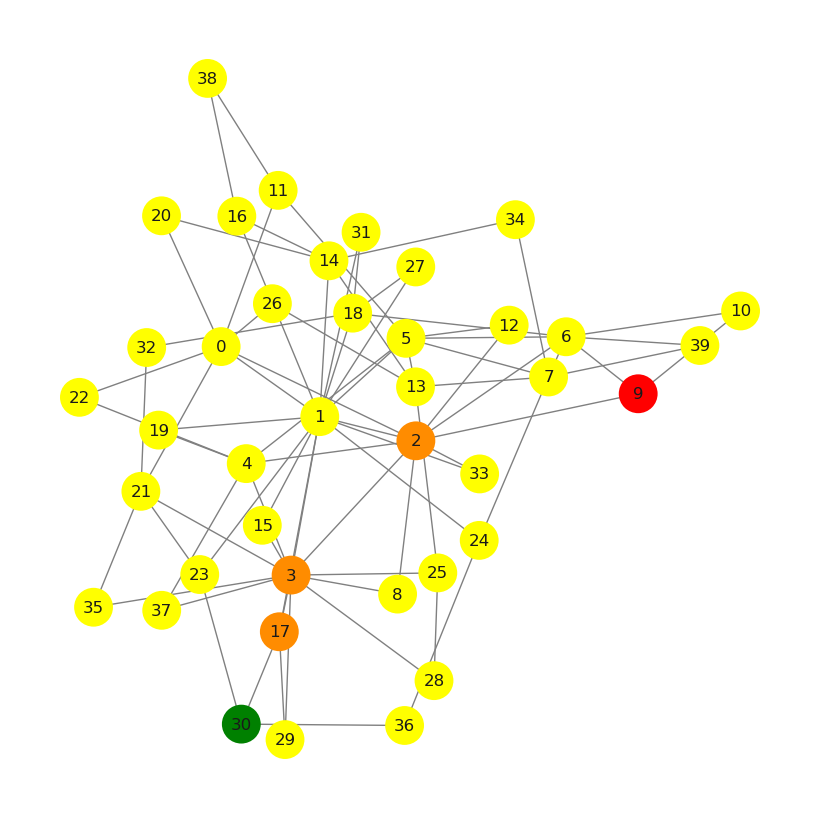

Nós do trajeto: [30 17  3  2  9]


In [34]:
# agora vamos implementar uma função que retorna o trajeto mais curto entre dois nós

### função que calcula a distância de um nó para outro a partir da matriz D
def distancia_ij(no_i, no_j, matriz_D):
    d_ij = matriz_D[no_i, no_j]
    return int(d_ij)


#### Função que retorna os nós que formam o menor caminho entre dois nós
def Visitados(no_i, no_j, lista_adj, graus_rede):
    d, Q = menor_distancia(no_i, no_j, lista_adj, graus_rede)
    # Vetor para guardar o caminho: tamanho d+1
    visitados = np.zeros(d + 1, dtype=int)
    visitados[d] = int(no_j)  # Último nó é o destino

    # Vamos reconstruir de trás pra frente
    atual = int(no_j)

    for camada in range(d-1, -1, -1):  # de d-1 até 0
        possiveis = Q[camada]
        idx = np.random.randint(0, len(possiveis))
        no = possiveis[idx]
        V_no = vizinho_no(no, graus_rede, lista_adj)
        teste = verifica(atual, V_no)
        
        while teste == -2:
            idx = np.random.randint(0, len(possiveis))
            no = possiveis[idx]
            V_no = vizinho_no(no, graus_rede, lista_adj)
            teste = verifica(atual, V_no)

        visitados[camada] = int(no)
        atual = int(no)
    return visitados  # Contém o caminho na ordem correta



# vamos visualizar
no_partida = np.random.randint(N) # parte de um nó aleatório
no_destino = np.random.randint(N) # destino é um nó aleatório
while no_destino == no_partida: # garante que nó de partida seja diferente do nó destino
    no_destino = np.random.randint(N) 
    
    
nos_que_formam_trajeto = Visitados(no_partida, no_destino, lista_adj, graus_rede)

# Criando grafo
G_barabasi = nx.Graph()
G_barabasi.add_edges_from(rede_barabasi)

# Definindo cores
cores = []
for node in G_barabasi.nodes():
    if node == no_partida:
        cores.append("green")  # nó de partida
    elif node == no_destino:
        cores.append("red")    # nó de destino
    elif node in nos_que_formam_trajeto:
        cores.append("darkorange") # nós do trajeto
    else:
        cores.append("yellow") # demais nós

plt.figure(figsize=(8,8))
nx.draw(G_barabasi, with_labels=True, node_color=cores, 
        node_size=700, edge_color="gray")
plt.show()


print("Nós do trajeto:", nos_que_formam_trajeto)

In [18]:
### animação 
import os
import imageio

filenames = []

for i in range(50):
    # vamos visualizar
    no_partida = np.random.randint(N) # parte de um nó aleatório
    no_destino = np.random.randint(N) # destino é um nó aleatório
    while no_destino == no_partida: # garante que nó de partida seja diferente do nó destino
        no_destino = np.random.randint(N) 


    nos_que_formam_trajeto = Visitados(no_partida, no_destino, lista_adj, graus_rede)

    # Criando grafo
    G_barabasi = nx.Graph()
    G_barabasi.add_edges_from(rede_barabasi)

    # Definindo cores
    cores = []
    for node in G_barabasi.nodes():
        if node == no_partida:
            cores.append("green")  # nó de partida
        elif node == no_destino:
            cores.append("red")    # nó de destino
        elif node in nos_que_formam_trajeto:
            cores.append("darkorange") # nós do trajeto
        else:
            cores.append("yellow") # demais nós

    plt.figure(figsize=(8,8))
    nx.draw(G_barabasi, with_labels=True, node_color=cores, 
            node_size=700, edge_color="gray")
    
    # Salva o gráfico antes de fechar
    filename = f'{i}.png'
    plt.savefig(filename)
    plt.close()  # Fecha a figura para economizar memória
    filenames.append(filename)
    
    
    
# Cria o GIF
# Cria o GIF mais lento
with imageio.get_writer('trajeto-mais-curto.gif', mode='I', duration=0.8) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

# Remove os arquivos temporários
for filename in set(filenames):
    os.remove(filename)


/tmp/ipykernel_30897/2276770802.py:49: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
